In [1]:
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import Dataset
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer, EvalPrediction

%matplotlib inline

In [2]:
# Load split data
train_df = pd.read_csv("./data/alpha_vantage_train.csv")
test_df = pd.read_csv("./data/alpha_vantage_test.csv")

In [3]:
ds_train = Dataset.from_pandas(train_df)
ds_test = Dataset.from_pandas(test_df)

ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 16688
})

In [4]:
def condense_label(example):
    l = example['label']
    if l == 0 or l == 1:
        example['label'] = 0
    elif l == 2:
        example['label'] = 1
    elif l == 3 or l== 4:
        example['label'] = 2
    return example
    
ds_train_condensed = ds_train.map(condense_label)
ds_test_condensed = ds_test.map(condense_label)


Map:   0%|          | 0/16688 [00:00<?, ? examples/s]

Map:   0%|          | 0/7152 [00:00<?, ? examples/s]

Text(0.5, 1.0, 'Dataset size: 16688')

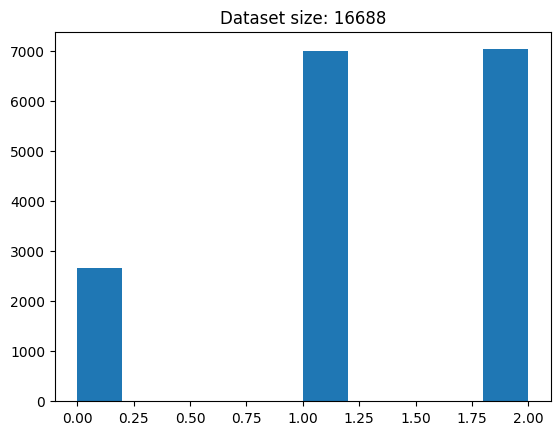

In [5]:
_ = plt.hist(ds_train_condensed['label'])
plt.title(f'Dataset size: {ds_train_condensed.shape[0]}')

Loading Bert model

In [6]:
# MODEL_NAME = "google-bert/bert-base-uncased"
MODEL_NAME = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


def tokenize(datapoint):
    return tokenizer(datapoint['text'], padding='max_length', truncation=True)


tokenized_train_df = ds_train_condensed.map(tokenize, batched=True)
tokenized_test_df = ds_train_condensed.map(tokenize, batched=True)

E:\Academics\NEU\DS5230 - USML\Assignments\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/16688 [00:00<?, ? examples/s]

Map:   0%|          | 0/16688 [00:00<?, ? examples/s]

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

In [17]:
training_args = TrainingArguments(
    output_dir="fin_bert",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5)

metric = evaluate.load("accuracy")

In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    y_pred = np.argmax(logits, axis=-1)
    return metric.compute(predictions=y_pred, references=labels)

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_df,
    eval_dataset=tokenized_test_df,
    compute_metrics=compute_metrics,
)

trainer.train()

E:\Academics\NEU\DS5230 - USML\Assignments\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.757000,0.677927,0.701590
2,0.520300,0.646478,0.735549
3,0.371000,0.805298,0.738680
4,0.224600,1.279175,0.732418
5,0.064800,1.418034,0.732177


TrainOutput(global_step=3030, training_loss=0.342402450282975, metrics={'train_runtime': 2108.5847, 'train_samples_per_second': 22.973, 'train_steps_per_second': 1.437, 'total_flos': 1.274521395474432e+16, 'train_loss': 0.342402450282975, 'epoch': 5.0})

In [22]:
# Define the evaluation metric
def eval_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    report = classification_report(p.label_ids, preds)
    print(report)
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc}


# Define training arguments
eval_args = TrainingArguments(
    output_dir="./results_bert",
    do_train=False,
    do_eval=True,
    per_device_eval_batch_size=16,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_test_df,
    compute_metrics=eval_metrics,
)

# Run evaluation
eval_result = trainer.evaluate()

# Print results
print(eval_result)

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1167
           1       0.64      0.69      0.66      1536
           2       0.79      0.74      0.76      1449

    accuracy                           0.73      4152
   macro avg       0.74      0.74      0.74      4152
weighted avg       0.74      0.73      0.73      4152

{'eval_loss': 1.4180340766906738, 'eval_model_preparation_time': 0.0011, 'eval_accuracy': 0.7321772639691715, 'eval_runtime': 50.8162, 'eval_samples_per_second': 81.706, 'eval_steps_per_second': 5.116}
